In [6]:
%%HTML
<!--
<style>
.container {width:70% !important;}
</style>-->

In [1]:
%matplotlib inline

from __future__ import division
import kwant
from matplotlib import pyplot
import matplotlib
import numpy as np
import scipy.linalg
import scipy.sparse.linalg
import kwant.graph.dissection
import tinyarray as ta
import math
from matplotlib.patches import Circle
from math import sqrt
from cmath import exp
subplot = pyplot.subplot
matplotlib.rcParams['figure.dpi'] = 320
matplotlib.rcParams['figure.figsize'] = (10, 5)

sys = kwant.Builder()
lat = kwant.lattice.square()
sys[lat.shape((lambda pos: pos[0]**2 + pos[1]**2 < 8**2), (0,0))] = 10
sys[lat.neighbors()] = 1
sys = sys.finalized()
h = sys.hamiltonian_submatrix().real
reordering = np.r_[tuple(kwant.graph.slice(sys.graph, 0, 1))]
h_rgf = h[reordering][:, reordering]
dis = kwant.graph.dissection.edge_dissection(sys.graph, 1)
def flatten(a):
    x, y = a
    if isinstance(x, tuple):
        x = flatten(x)
    if isinstance(y, tuple):
        y = flatten(y)
    return x + y
dis = flatten(dis)
h_diss = h[dis][:, dis]

In [49]:
#Generate the system plot

def circle(pos):
    x, y = pos
    return x**2 + y**2 < 20

lat = kwant.lattice.triangular()
sys = kwant.Builder()
sys[lat.shape(circle, (0, 0))] = 0
sys[lat.neighbors()] = 1

lead_dirs = [lat.vec((-3, 1)), lat.vec((0, -1)), lat.vec((2, -1))]
for d in lead_dirs:
    lead = kwant.Builder(kwant.TranslationalSymmetry(d))
    lead[lat.wire((0, 0), 2.1)] = 0
    lead[lat.neighbors()] = 1
    sys.attach_lead(lead)

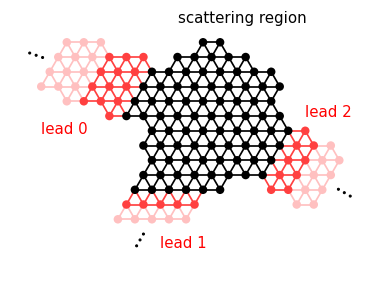

In [50]:
fig = kwant.plot(sys, show=False)
ax = pyplot.gca()
pyplot.text(-2, 5.5, 'scattering region', size=15)
pyplot.text(-10, -1, 'lead 0', color='red', size=15)
pyplot.text(-3, -7.7, 'lead 1', color='red', size=15)
pyplot.text(5.5, 0, 'lead 2', color='red', size=15)

for dir, offset in zip(lead_dirs, [10.5, 8, 8.6]):
    dir = np.array(dir) / math.sqrt(np.dot(dir, dir))
    for i in [0, 0.4, 0.8]:
        ax.add_artist(Circle(dir * (offset + i), 0.06, fc='k'))

pyplot.axis('off')
pyplot.xlim((-11, 9))
pyplot.ylim((-8, 6))
fig.tight_layout()
fig.set_size_inches(*(5, 3.75))
fig.savefig("tbsys.png")

![](http://kwant-project.org/common/kwant_logo.png)

Numerical simulation of quantum transport
-----------------------------------------

Christoph Groth, Michael Wimmer, **Anton Akhmerov**, and Xavier Waintal

## I will tell

1. What is a scattering problem.
2. What algorithms exist to solve it.
3. How to use Kwant to define and solve such problems (here we run some code).

   * If you want to run code and don't have Kwant yet, get an account at http://cloud.sagemath.com/ now.
   * Also please fill out the Kwant user survey at  
   http://kwant-project.org/2015-survey

# The tight-binding scattering problem

<img src="files/tbsys.png" style="width: 450px;"/>

> Now to get conductance and other observables,  
> we only need to calculate $\Sigma_{\textrm{lead}}$, $G^R$, $G^<$, and we're done.

(that is what one mostly hears)

But there is a more intuitive definition.

# The tight-binding scattering problem

<img src="files/tbsys.png" style="width: 450px;"/>

has the Hamiltonian:

$$
H = \begin{pmatrix}
    \ddots & V_L\\
    V_L^\dagger & H_{L}& V_{L}\\
    & V_{L}^\dagger & H_L & V_L\\
    & & V_L^\dagger &H_S\\
  \end{pmatrix}, \quad
\psi = 
    \begin{pmatrix}
    \vdots \\
    \psi_2 \\
    \psi_1 \\
    \psi_S
    \end{pmatrix}
$$

($H_L$ and $V_L$ are block-diagonal if there are many leads)

##Modes in the leads

Since the leads are translationally invariant,  
the lead wave function can be decomposed into eigenvectors of translation (lead modes)

$$
\psi_j = \lambda^j \psi_0,
$$

the modes in the leads satisfy

$$
V_L \psi_0 + H \lambda \psi_0 + V_L^\dagger \lambda^2 \psi_0 = 0,
$$

or in a matrix form:

$$
\begin{pmatrix}
    -V_L^{-1} H_L & -V_L^{-1} \\
    V_L^\dagger & 0
  \end{pmatrix}
  \begin{pmatrix}
    \psi_0 \\
    V_L^\dagger \psi_1
  \end{pmatrix}
  = \lambda^{-1}
  \begin{pmatrix}
    \psi_0 \\
    V_L^\dagger \psi_1
  \end{pmatrix}
$$

...or in a more stable form (and reduced basis):

$$
\begin{pmatrix}
    i A^\dagger\tilde{H}^{-1}B & -A^\dagger\tilde{H}^{-1}B \\
    -1 + iB^\dagger\tilde{H}^{-1}B & -B^\dagger\tilde{H}^{-1}B
  \end{pmatrix}
  \begin{pmatrix}
    \tilde{\psi_0}\\
    \tilde{\psi_1}
  \end{pmatrix}
  = \lambda^{-1}
  \begin{pmatrix}
    A^\dagger\tilde{H}^{-1}A & -1 - iA^\dagger\tilde{H}^{-1}A \\
    B^\dagger\tilde{H}^{-1}A & -iB^\dagger\tilde{H}^{-1}A
  \end{pmatrix}
  \begin{pmatrix}
    \tilde{\psi_0}\\
    \tilde{\psi_1}
  \end{pmatrix},
$$

$
  \tilde{H} = H_L + i AA^\dagger + i BB^\dagger,\quad V_L = A B^\dagger, \quad \tilde{\psi}_0 = B^+ \psi_0, \quad \tilde{\psi}_1 = A^+ \psi_1
$

##Incoming and outgoing modes

Split all the eigenvectors into incoming, outgoing and evanecsent, such that:

$$\langle\psi_{\textrm{in}}|\hat{I}|\psi_{\textrm{in}}\rangle = 1$$
$$\langle\psi_{\textrm{out}}|\hat{I}|\psi_{\textrm{out}}\rangle = -1$$
$$\langle\psi_{\textrm{evan}}|\hat{I}|\psi_{\textrm{out}}\rangle = 0, \quad |\lambda_{\textrm{evan}}| < 1$$


## Finally, the equations to solve

Substituting the lead modes into Hamiltonian gives a linear system:

$$
\begin{split}
\begin{pmatrix}
-  U_{\text{out}} & 1 \\
V_{L}^\dagger U_{\text{out}}\Lambda_{\text{out}} & H_\text{S}
\end{pmatrix}
\begin{pmatrix}
\mathbf{S}\\ \psi_S
\end{pmatrix}
=
\begin{pmatrix}
U_{\text{in}}\\
-V_{\text{L}}^\dagger U_{\text{in}} \Lambda_{\text{in}}
\end{pmatrix}
\end{split},
$$

with $U_{\text{in}}$ and $U_{\text{out}}$ wave functions of incoming and outgoing modes, and $\Lambda\equiv \textrm{diag}(\lambda_i)$. 

From now on, we only need to write down these linear equations and solve them.

(NB: if we start by eliminating $\mathbf{S}$, the rhs becomes $H_S + \Sigma$) 

##Solving a linear system

Take a tight-binding system, assign \#'s to sites, write down the matrix

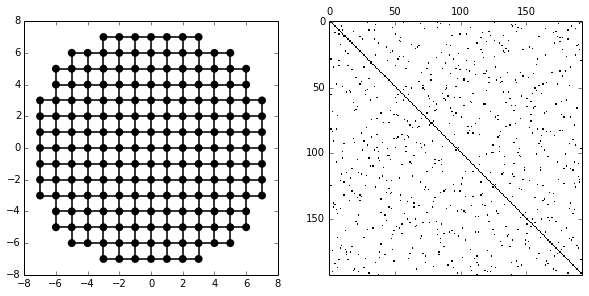

In [2]:
kwant.plot(sys, ax=subplot(121, aspect='equal'), show=False)
h = sys.hamiltonian_submatrix().real
pyplot.spy(h, axes=subplot(122));

## Naive solution

Perform gaussian elimination beginning to end:

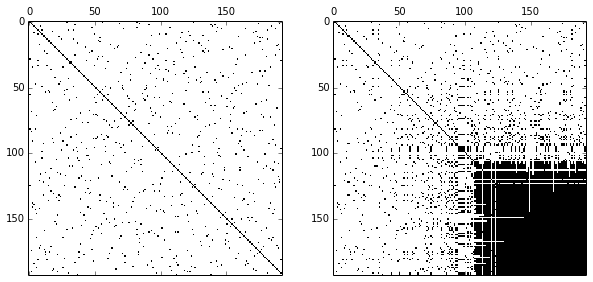

In [3]:
pyplot.spy(h, axes=subplot(1, 2, 1))
p, l, u = scipy.linalg.lu(h)
pyplot.spy(l + u, axes=subplot(1, 2, 2));

## Better idea (what most physicists would do)

Rearrange the sites into slices  
(also known as *recursive Green's functions*)

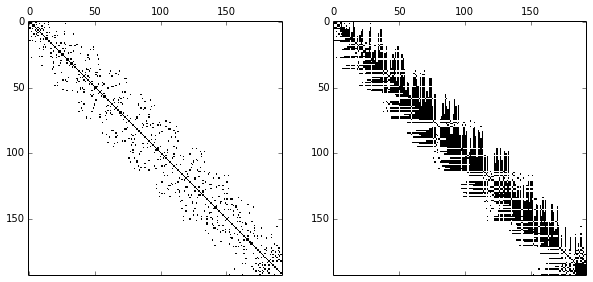

In [4]:
pyplot.spy(h_rgf, axes=subplot(1, 2, 1))
p, l, u = scipy.linalg.lu(h_rgf)
pyplot.spy(l + u, axes=subplot(1, 2, 2));

##What sparse linear algebra packages do

A hierarchic rearrangement (nested dissection)

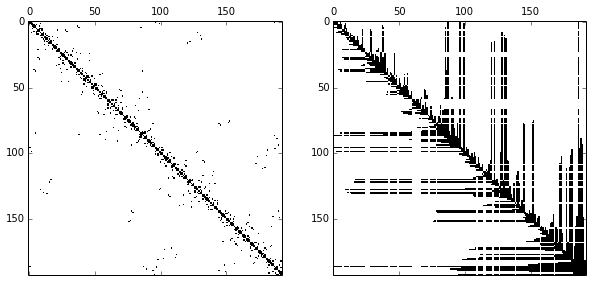

In [5]:
pyplot.spy(h_diss, axes=subplot(1, 2, 1))
p, l, u = scipy.linalg.lu(h_diss)
pyplot.spy(l + u, axes=subplot(1, 2, 2));

#The difference between two methods

![](files/time.png)

...is quite big.

##Algorithm of how to solve the scattering problem

1. Construct a linear system of equations  
   (the one with lead modes)
2. Solve it efficiently  
   (so use a sparse linear algebra library)

Now let us solve some problems :-)

##Before we begin

<img src="http://imgs.xkcd.com/comics/python.png" alt="import antigravity" style="height: 600px;"/>

(Source: http://xkcd.com, CC-BY-NC)

If you do not know python yet, you are missing a lot of fun.

Defining tight-binding systems (in kwant)
-----------------------------------------

* There are many different tight binding systems
* There are only few sparse linear algebra libraries
* Libraries know of *graphs*, systems know of *lattices*, *spins*, *superconductors*, and many more.

So let's separate *defining* the system:

    kwant.Builder

from *solving* it:

    kwant.System

##An example

Quantum Hall effect in a graphene with a quantum point contact

* Import the required packages

In [26]:
%matplotlib inline
from matplotlib import pyplot
import kwant

* Create the system and a lattice

In [27]:
import numpy as np
sqrt = np.sqrt
hallbar = kwant.Builder()
graphene = kwant.lattice.general([[1, 0], [1/2, sqrt(3)/2]],  # Unit vectors
                                 [[0, 0], [0, 1/sqrt(3)]])  # Site positions

* Define the *shape* of the scattering region

In [28]:
def scattering_region(pos):
    x, y = pos
    return -30 < x < 30 and -30 < y < 30

def mu(site, B, v):
    return v * np.tanh(site.pos[0]/70)

hallbar[graphene.shape(scattering_region, (0, 0))] = mu

## Example (continued)

* Define the value of the hoppings (it depends on magnetic field and coordinates)
* Add the hoppings to the system
* Remove dangling bonds

In [29]:
def hopping(site1, site2, B, v):
    x1, y1 = site1.pos
    x2, y2 = site2.pos
    return -1 * exp(1j * B * (x1 - x2) * (y1 + y2))

hallbar[graphene.neighbors(1)] = hopping
# graphene.neighbors(2) for next-nearest neighbors

hallbar.eradicate_dangling()

##Example (continued further)

* Repeat the same for the leads.  
  Leads are similar, only they have a *translational symmetry*

In [30]:
lead = kwant.Builder(kwant.TranslationalSymmetry((1, 0)))

def lead_shape(pos):
    return -30 < pos[1] < 30

lead[graphene.shape(lead_shape, (0, 0))] = lambda site, B, v: -v
lead[graphene.neighbors()] = hopping

* Attach the leads

In [31]:
hallbar.attach_lead(lead)

lead = kwant.Builder(kwant.TranslationalSymmetry((-1, 0)))

def lead_shape(pos):
    return -30 < pos[1] < 30

lead[graphene.shape(lead_shape, (0, 0))] = lambda site, B, v: v
lead[graphene.neighbors()] = hopping

hallbar.attach_lead(lead);

## Example (ready to solve)

* Check the result

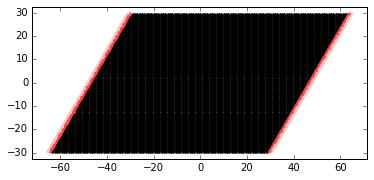

In [32]:
kwant.plot(hallbar, site_size=1);

* *Finalize* the system

In [33]:
hallbar = hallbar.finalized()

## Example (finally)

* Solve linear systems!

In [35]:
exp = np.exp

In [ ]:
Bvals = np.linspace(0.1, 0.4, 200)
conductances = [kwant.smatrix(hallbar, 0, args=(B, 0.2)).transmission(0, 1)
                for B in Bvals]

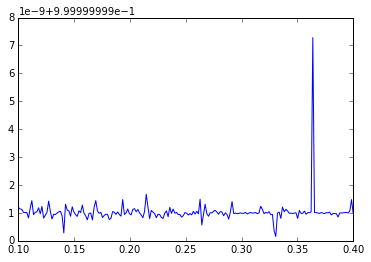

In [37]:
pyplot.plot(Bvals, conductances);

##Example: solve more

* calculate local density of states

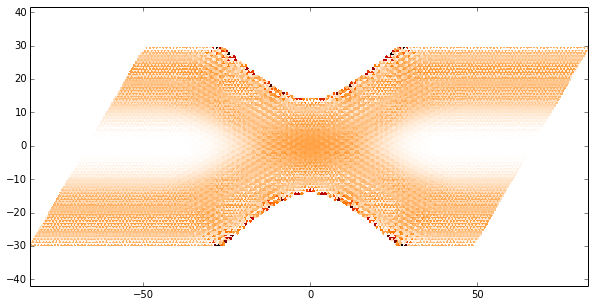

In [14]:
ldos = kwant.solvers.default.ldos(hallbar, 0.20, args=[0.01])
kwant.plotter.map(hallbar, ldos, colorbar=False, cmap='gist_heat_r');

## Exact diagonalization

* Find 6 eigenstates closest to Fermi level

In [15]:
h = hallbar.hamiltonian_submatrix(sparse=True).tocsc()
scipy.sparse.linalg.eigsh(h, sigma=0.1)[0]

array([ 0.09658392,  0.10469133,  0.08859576,  0.1129415 ,  0.08079808,
        0.12134041])

##One last image

Distribution of supercurrent in a disordered Josephson junction

<img src="files/vortices.png" style="width: 500px;"/>

##Conclusions

1. Quantum transport is as easy as defining and solving linear systems of equations.
2. Defining tight such systems can be made easy.
3. Solving them is also easy if using good libraries and clever algorithms.

Check Kwant out at <http://kwant-project.org>

##More code examples:

* Basic stuff: http://downloads.kwant-project.org/examples/
* Topological stuff: http://topocondmat.org
* My favorite: http://arxiv.org/abs/1408.1563 (see ancillary files)
* For a reference: 

#Examples from research

##Statistical topological insulators (arXiv:1212.6191)

* Like topological insulators, but protected also in presence of disorder that breaks the symmetry
* A quasi-1D $p_x$-wave superconductor has edge transmission $T\sim L^{-1/2}$, since the edges form disordered Majorana chains at the critical point
* Doubling the number of sites per unit cell localizes the system

<img src="files/two_scalings.svg" style="width: 600px;"/>

##Statistical topological insulators (arXiv:1212.6191)

* Any translationally invariant lattice with 1 Majorana fermion per unit cell becomes metallic $T\sim \log(L)$ after adding disorder.

<img src="files/d_2STI_scaling.svg" style="width: 600px;"/>

##Soft gap in Majorana wires (in preparation)

* What role does geometry of the nanowire experiment play?

<img src="files/rendered_wire.png" style="width: 300px;"/>

* Different transverse modes in the wire have different flight times.

<img src="files/modes.svg" style="width: 400px;"/>

* Induced gap is inversely proportional to the flight time

$$\Delta \sim \frac{\hbar L}{v_f \cos\psi}$$

* In ballistic samples the induced superconducting gap becomes soft: $\rho(E) \sim |E|$, for $|E| < \Delta_{\textrm{max}}$

<img src="files/wire_dos.png" style="width: 400px;"/>

* Disorder kills the trajectories with longest flight time first.
* There is a large range of disorder strengths, where the gap is soft and Majorana fermions are present

<img src="files/majorana.png" style="width: 400px;"/>

**Thank you all.**  
**The end.**

In [2]:
out = !ipython nbconvert kwant_presentation.ipynb --to slides